In [51]:
import sys
sys.path.append("../")
import re
from os.path import join
from IPython.display import display

import matplotlib.pyplot as plt
import joblib
import pandas as pd
import numpy as np
import torch
import torch.utils.data as data_utils
from matplotlib.colors import ListedColormap
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import MinMaxScaler

from lolip.attacks.torch.projected_gradient_descent import ProjectedGradientDescent
from lolip.models.torch_utils.archs import *
from lolip.variables import auto_var
from lolip.models.torch_model import TorchModel
from utils import params_to_dataframe

Train accuracy:  1.0
Test accuracy:  1.0


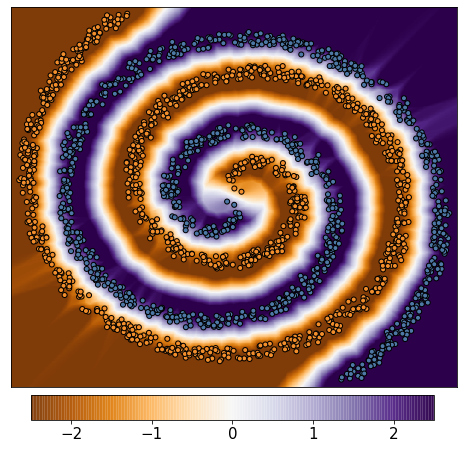

In [73]:
h = 0.05
def plot_boundary(clf, X, y, X_test=None, y_test=None):
    fig, ax = plt.subplots(figsize=(8, 7))

    cm = plt.cm.PuOr
    #cm = ListedColormap(['#F28E2C', '#4E79A7'])
    #cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    cm_bright = ListedColormap(['#F28E2C', '#4E79A7'])
    
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    if Z.max() > 1.:
        #Z = MinMaxScaler().fit_transform(Z.reshape(-1, 1)).reshape(-1)
        Z = Z

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    #imshow_handle = plt.contourf(xx, yy, Z, cmap=cm, alpha=.8, vmin=0, vmax=1)
    imshow_handle = plt.pcolormesh(xx, yy, Z, cmap=cm, alpha=.8, vmin=-2.5, vmax=2.5)
    imshow_handle.set_clim(-2.5, 2.5)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright,
               edgecolors='black', s=25)
    # and testing points
    #plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
    #           alpha=0.6, edgecolors='black', s=25)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    
    ax = plt.axes([0.16, 0.06, 0.7, 0.05])
    #plt.title("Probability")
    cbar = plt.colorbar(imshow_handle, cax=ax, orientation='horizontal')
    cbar.ax.tick_params(labelsize=15) 
    #cbar.set_ticks([])
    
plot_boundary(model, trnX, trny, tstX, tsty)
print("Train accuracy: ", (model.predict(trnX) == trny).mean())
print("Test accuracy: ", (model.predict(tstX) == tsty).mean())

plt.savefig("../figs/sprial.9_smooth.png", transparent=True)

In [58]:
class smoothCLF():
    def __init__(self, r):
        self.r = r
        
    def fit(self, X, y):
        self.trnX = X
        self.trny = y
        
    def predict(self, X):
        pred = []
        for x in X:
            dist = np.linalg.norm(self.trnX - x, axis=1, ord=2)
            pred.append(dist[self.trny == 0].min() - dist[self.trny == 1].min())
        pred = np.array(pred)
        return (np.sign(pred) + 1) / 2
    
    def predict_proba(self, X):
        pred = np.zeros((len(X), 2))
        for i, x in enumerate(X):
            dist = np.linalg.norm(self.trnX - x, axis=1, ord=2)
            pred[i][1] = (dist[self.trny == 0].min() - dist[self.trny == 1].min())
        pred[:, 0] = -pred[:, 1]
        return pred / 2 / self.r

In [54]:
def twospirals(n_points, noise=.5, random_seed=0):
    """
     Returns the two spirals dataset.
    """
    random_state = np.random.RandomState(random_seed)
    n = np.sqrt(random_state.rand(n_points,1)) * 780 * (2*np.pi)/360
    d1x = -np.cos(n)*n + random_state.rand(n_points,1) * noise
    d1y = np.sin(n)*n + random_state.rand(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))), 
            np.hstack((np.zeros(n_points),np.ones(n_points))))

trnX, trny = twospirals(1000, 0.9)
tstX, tsty = twospirals(1000, 0.9)

dist = pairwise_distances(trnX, metric='chebyshev')
for i in range(len(trnX)):
    for j in range(len(trnX)):
        if trny[i] == trny[j]:
            dist[i][j] = np.inf
dist.min()

0.7052012353399588

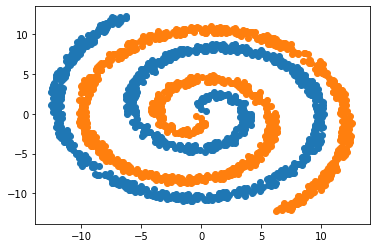

In [23]:
plt.scatter(trnX[trny==0, 0], trnX[trny==0, 1])
plt.scatter(trnX[trny==1, 0], trnX[trny==1, 1])

In [22]:
attack = ProjectedGradientDescent(
    model_fn=model.model,
    norm=np.inf,
    eps=eps,
    eps_iter=eps/5,
    nb_iter=10,
    preprocess_img=False,
    device='cpu',
)
print("adv trn acc: ", (model.predict(attack.perturb(trnX, trny)) == trny).mean())
print("adv tst acc: ", (model.predict(attack.perturb(tstX, tsty)) == tsty).mean())

adv trn acc:  0.99
adv tst acc:  0.99


In [10]:
ttt = attack.perturb(tstX, tsty)

In [32]:
trny
model.predict(trnX)

array([0., 0., 0., ..., 1., 1., 1.])

In [60]:
eps = 0.35
batch_size = 128
auto_var.set_variable_value("random_seed", 0)
model = smoothCLF(0.35)

_ = model.fit(trnX, trny)
print((model.predict(trnX) == trny).mean())
print((model.predict(tstX) == tsty).mean())
model.predict_proba(tstX)

1.0
1.0


array([[ 3.45436967, -3.45436967],
       [ 2.50214869, -2.50214869],
       [ 3.43956035, -3.43956035],
       ...,
       [-3.53679245,  3.53679245],
       [-2.62246843,  2.62246843],
       [-2.27364012,  2.27364012]])

In [59]:
eps = 0.35
batch_size = 128
auto_var.set_variable_value("random_seed", 0)
#trnX, trny, tstX, tsty = auto_var.get_var_with_argument("dataset", "halfmoon-800-0.25")
#model = TorchModel(lbl_enc=None, n_features=(2, ), n_classes=2, loss_name="ce", architecture="LargeMLP", epochs=70, learning_rate=1e-2, device="cpu", batch_size=batch_size, optimizer="adam")
#model = TorchModel(lbl_enc=None, n_features=(2, ), n_classes=2, loss_name="advce", architecture="LargeMLP", epochs=160, learning_rate=1e-2, device="cpu", batch_size=batch_size, optimizer="adam", eps=eps, norm=np.inf)
model = TorchModel(lbl_enc=None, n_features=(2, ), n_classes=2, loss_name="stradesce", architecture="LargeMLP", epochs=70, learning_rate=1e-2, device="cpu", batch_size=batch_size, optimizer="adam", eps=eps, norm=np.inf)

_ = model.fit(trnX, trny, verbose=0)
print((model.predict(trnX) == trny).mean())

Epoch 1:   0%|          | 0/16 [00:00<?, ?it/s]

lr: 0.01, opt: adam, loss: stradesce, arch: LargeMLP, dataaug: None, batch_size: 128, momentum: 0.0, weight_decay: 0.0


Epoch 1:  75%|███████▌  | 12/16 [00:02<00:01,  3.97it/s]


KeyboardInterrupt: 